In [84]:
import os
import urllib
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

url = "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_fname = os.path.basename(url)

f = urllib.request.urlopen(url)
with open(data_fname, 'wb') as fout:
    fout.write(f.read())

In [85]:
data_shape = (28, 20)
ff = scipy.io.loadmat(data_fname, squeeze_me=True, struct_as_record=False)
ff = ff['ff']
ff = ff.T.reshape((-1, *data_shape))

In [133]:

def show_examples(data, n_start=None, n_end=None, n_cols=20, thumbnail_cb=None):
    n_start = n_start or 0
    n_end = n_end or len(data)

    if n_start >= n_end:
        raise ValueError("Must have n_start < n_end.")
    nump = n_end - n_start
    img_rows, img_cols = data[0].shape
    n_rows = int(np.ceil(nump / float(n_cols)))
    fig = np.zeros((img_rows * n_rows, img_cols * n_cols))

    for k, x in enumerate(data[n_start:n_end]):
        r = k // n_cols
        c = k % n_cols

        fig[r * img_rows:(r+1)*img_rows, c*img_cols:(c+1)*img_cols] = x

        if thumbnail_cb is not None:
            thumbnail_cb(locals())

    plt.figure(figsize=(12,10))
    plt.imshow(fig, cmap='gray')
    plt.axis('off')
    plt.tight_layout()


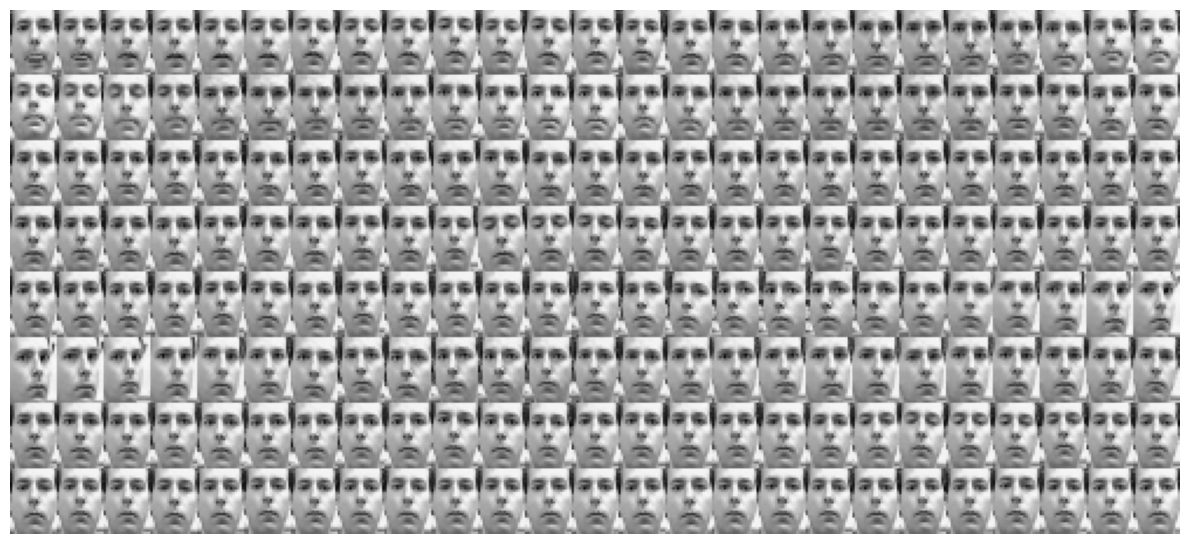

In [134]:
show_examples(ff, n_end=200, n_cols=25)

In [86]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.base_model = base_model

        base_output_size = self._get_output_size()
        self.linear_latent = nn.Linear(base_output_size, latent_dim)

    def _get_output_size(self):
        # builds a dummy batch containing one dummy tensor
        # full of zeroes with the same shape as the inputs
        device = next(self.base_model.parameters()).device.type
        dummy = torch.zeros(1, *self.input_shape, device=device)
        # sends the dummy batch through the base model to get 
        # the output size produced by it
        size = self.base_model(dummy).size(1)
        return size

    def forward(self, x):
        base_output = self.base_model(x)
        z = self.linear_latent(base_output)
        return z

In [87]:
input_shape = (1, 28, 20)
latent_dim = 2

encoder_base_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(np.prod(input_shape), 2048),
    nn.LeakyReLU(),
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
)

decoder = nn.Sequential(
    nn.Linear(latent_dim, 2048),
    nn.LeakyReLU(),
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    nn.Linear(2048, np.prod(input_shape)),
    nn.Unflatten(1, input_shape),
)

encoder = Encoder(input_shape, latent_dim, encoder_base_model)

In [88]:
ff_t = torch.tensor(ff, requires_grad=False).float().unsqueeze(1) / 255.0

In [89]:
# z = encoder_base_model(ff)
z = encoder(ff_t)
x_hat = decoder(z)

In [92]:
x.shape

torch.Size([1, 28, 20])

In [110]:

def plot_input_output(x, model):
    if x.ndim < 4:
        x = x.unsqueeze(0)
    x_hat = model(x)

    _, ax = plt.subplots(ncols=2, figsize=(8, 5))
    ax[0].imshow(x[0][0].detach().numpy())
    ax[1].imshow(x_hat[0][0].detach().numpy())
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

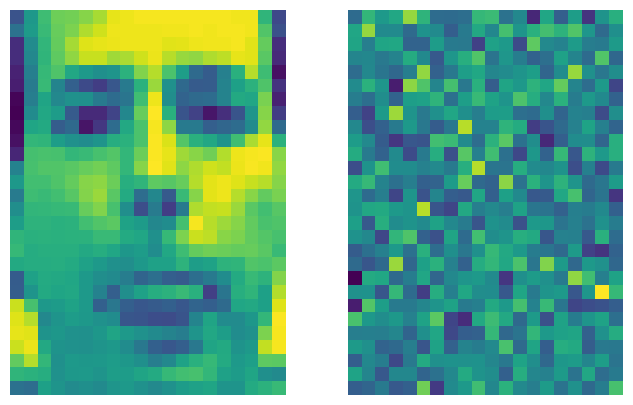

In [99]:
plot_input_output(ff_t[0])

Generates garbage because the model isn't trained yet!

Let's wrap the encoder and decoder together in a single object.

In [246]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model_ae = AutoEncoder(encoder, decoder)

In [247]:
faces_ds = torch.utils.data.TensorDataset(ff_t)
faces_dl = torch.utils.data.DataLoader(faces_ds, batch_size=20)

In [248]:
# training loop
loss_function = nn.MSELoss() # poor choice for image?
optim = torch.optim.Adam(model_ae.parameters(), 0.0003)

num_epochs = 10
train_losses = []

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, x in enumerate(faces_dl):
        x = x[0]
        model_ae.train()
        
        x_hat = model_ae(x)
        loss = loss_function(x_hat, x)
        loss.backward()
        optim.step()
        optim.zero_grad()
        batch_losses.append(np.array([loss.data.item()]))

    train_losses.append(
        np.array(batch_losses).mean(axis=0)
    )
    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}')

Epoch 001 | Loss >> 0.0129
Epoch 002 | Loss >> 0.0124
Epoch 003 | Loss >> 0.0123
Epoch 004 | Loss >> 0.0123
Epoch 005 | Loss >> 0.0124
Epoch 006 | Loss >> 0.0125
Epoch 007 | Loss >> 0.0125
Epoch 008 | Loss >> 0.0126
Epoch 009 | Loss >> 0.0127
Epoch 010 | Loss >> 0.0127


In [249]:

def plot_input_output(x, model):
    if x.ndim < 4:
        x = x.unsqueeze(0)
    x_hat = model(x)

    _, ax = plt.subplots(ncols=2, figsize=(8, 5))
    ax[0].imshow(x[0][0].detach().numpy())
    ax[1].imshow(x_hat[0][0].detach().numpy())
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

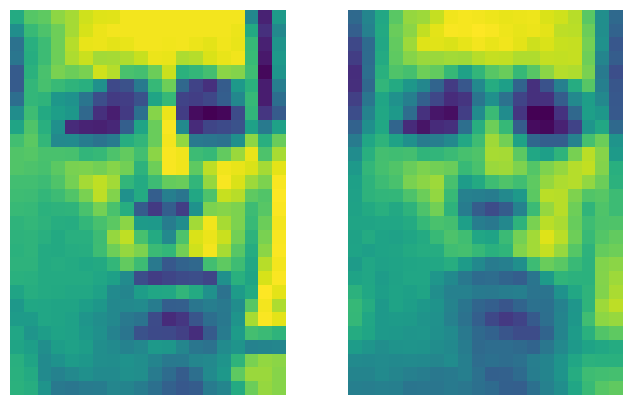

In [250]:
plot_input_output(ff_t[1900], model_ae)

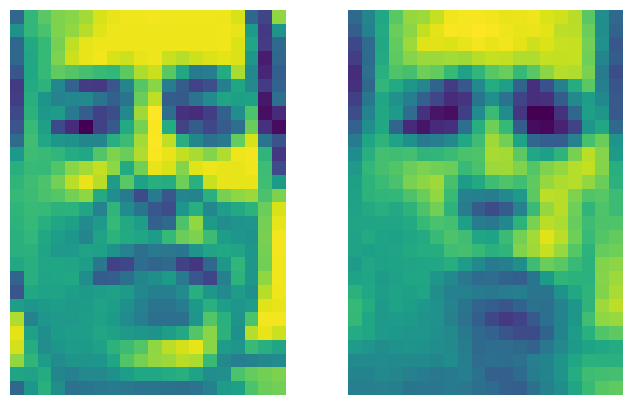

In [251]:
plot_input_output(ff_t[1050], model_ae)

All the reconstructed images seem identical!

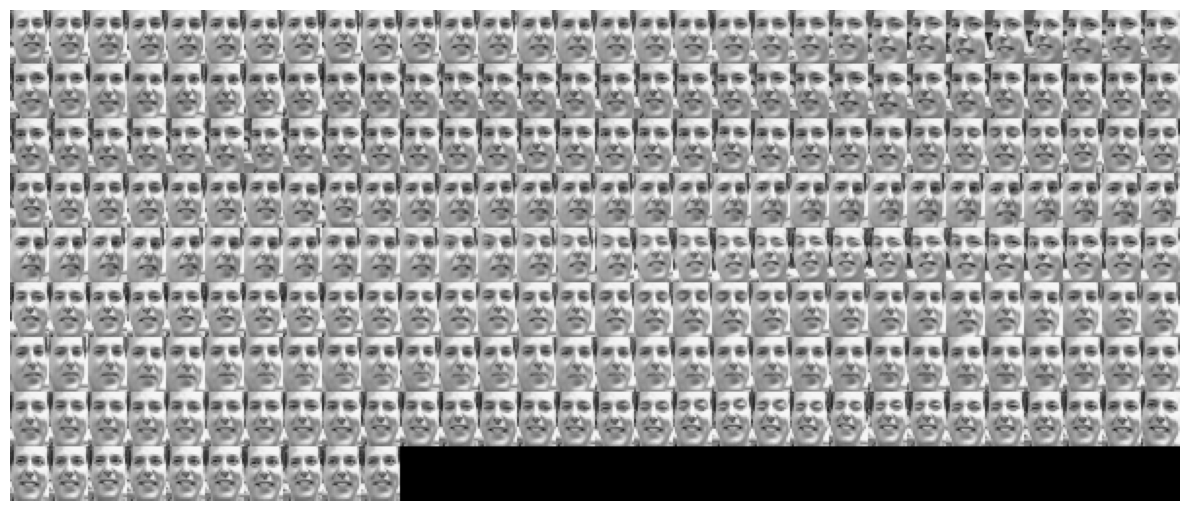

In [252]:
show_examples(ff, n_start=750, n_end=1000, n_cols=30)

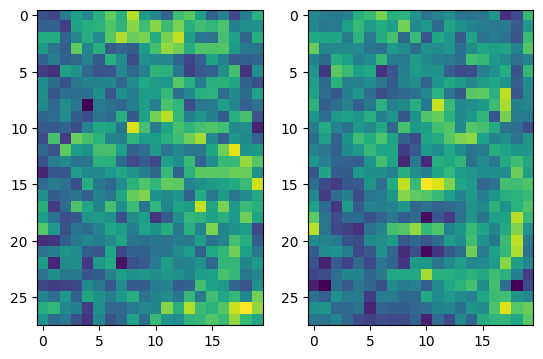

In [253]:
def generate(z: torch.tensor, model):
    x_hat = model.decoder(z)
    return x_hat.detach()


fig, ax = plt.subplots(ncols=2)

z = torch.tensor([[1.0, 0.0]])
x_hat = generate(z, model_ae)[0,0].detach()
ax[0].imshow(x_hat)

z = torch.tensor([[0.0, 3.0]])
x_hat = generate(z, model_ae)[0,0].detach()
ax[1].imshow(x_hat)



In [254]:
xt = torch.arange(0.0, 10.0, step=0.5)

Y_t, X_t = torch.meshgrid(xt, xt)
n_dims = X_t.shape
X_t = X_t.flatten().unsqueeze(0).T
Y_t = Y_t.flatten().unsqueeze(0).T
Z_t = torch.concat([X_t, Y_t], axis=1)
# Z_t = Z_t.reshape((*n_dims, 2))
X_t_hat = model_ae.decoder(Z_t)


In [255]:
n_plot = np.prod(n_dims)

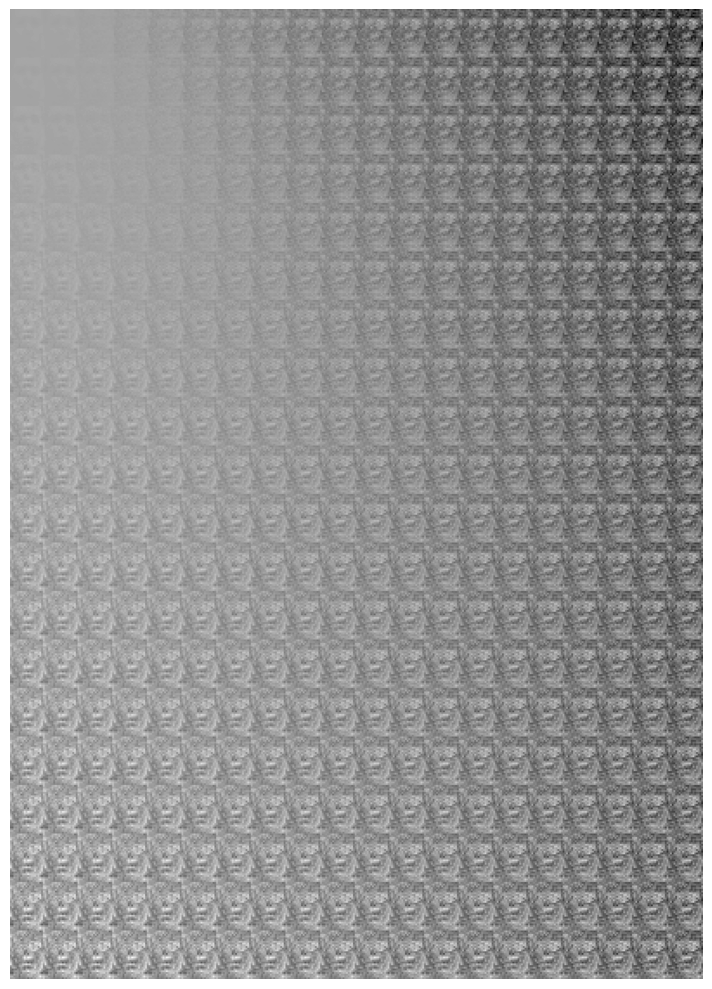

In [256]:
data = X_t_hat.detach().numpy()
img_rows, img_cols = 28, 20
n_rows = n_cols = int(np.sqrt(n_plot))

fig = np.zeros((img_rows * n_rows, img_cols * n_cols))

for k in range(n_plot):
    x = data[k,0]
    r = k // n_cols
    c = k % n_cols

    fig[r * img_rows:(r+1)*img_rows, c*img_cols:(c+1)*img_cols] = x

    # if thumbnail_cb is not None:
        # thumbnail_cb(locals())

plt.figure(figsize=(12,10))
plt.imshow(fig, cmap='gray')
plt.axis('off')
plt.tight_layout()